In [1]:
import re
import pandas as pd
import numpy as np
from collections import Counter
import urllib.request

import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from konlpy.tag import Okt

In [2]:
data_path = "../data/"
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", 
    filename=data_path + "shopping_ratings_total.txt")

('../data/shopping_ratings_total.txt',
 <http.client.HTTPMessage at 0x294e310d0>)

In [18]:
df = pd.read_table(data_path + "shopping_ratings_total.txt", names=['ratings', 'reviews']) # set column names
print(len(df))
print(df.head(5))

200000
   ratings                                            reviews
0        5                                            배공빠르고 굿
1        2                      택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2        5  아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3        2  선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4        5                  민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


# Data Preprocessing

In [19]:
# add new columns
df['label'] = df['ratings'].apply(lambda x: 1 if x>3 else 0) # 1: positive, 0: negative
df.head(5)

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [35]:
# remove non-Korean characters
df['reviews'].replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True, inplace=True) # convert non-Korean characters to blank
df['reviews'].replace("", np.nan, inplace=True) # convert blank to null

# remove null and duplicate values
print(df['ratings'].nunique(), df['reviews'].nunique(), df['label'].nunique()) # check unique values
df.drop_duplicates(subset=['reviews'], inplace=True) # drop duplicates
df.dropna(how='any', inplace=True) # drop null values
print(len(df), df.isnull().values.any()) # check null values
print(df['reviews'].nunique(), len(df)) # check unique values

4 199391 2
199391 False
199391 199391


In [32]:
# split total into train and test data
train_data, test_data = train_test_split(df, test_size=0.25, random_state=42) # random_state: seed
print(len(train_data), len(test_data), print(len(df)))

199391
149543 49848 None


<Axes: xlabel='label'>

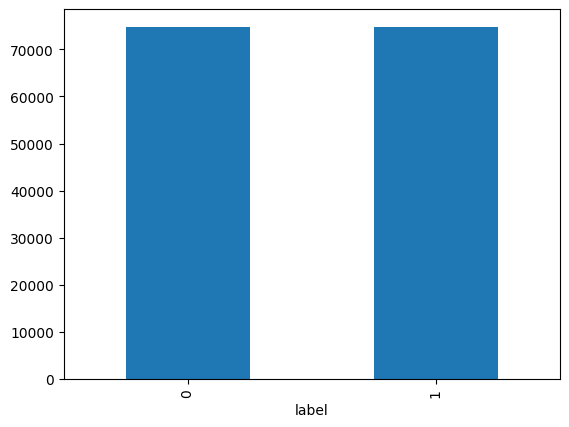

In [33]:
 # check if evenly distributed
train_data['label'].value_counts().plot(kind='bar')

# Tokenizing

In [36]:
okt = Okt()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

print(okt.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔', stem=True)) # test

['오다', '이렇다', '것', '도', '상품', '이라고', '차라리', '내', '가', '만들다', '게', '나다', '뻔']


In [37]:
train_data['tokenized'] = train_data['reviews'].apply(lambda x: okt.morphs(x)) # tokenize train data
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [word for word in x if not word in stopwords]) # remove stopwords

test_data['tokenized'] = test_data['reviews'].apply(lambda x: okt.morphs(x)) # tokenize test data
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [word for word in x if not word in stopwords]) # remove stopwords

In [41]:
print(train_data['tokenized'].head())

13249                          [우엉, 진짜, 흔적, 찾아볼수가, 옶, 어, 요]
40329                              [소재, 좋아요, 바느질, 상태, 안좋네요]
182405            [짧아요, 게다가, 벨, 크로, 접착, 력, 그리, 좋은, 편, 아니에요]
188396    [시원한, 재질, 이고, 보송해서, 편해요, 바닥, 미끄럼, 방지, 잘, 되어있고,...
135778         [안, 뜯어, 봐서, 모르겠고, 일, 제, 상품, 인지, 모르고, 구매, ㅉㅉ]
Name: tokenized, dtype: object


In [39]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

negative_count = Counter(negative_words)
positive_count = Counter(positive_words)

print(negative_count.most_common(20))
print(positive_count.most_common(20))

[('너무', 13169), ('요', 11773), ('안', 11688), ('배송', 9229), ('그냥', 8608), ('잘', 7825), ('로', 5779), ('했는데', 5664), ('별로', 5580), ('못', 5152), ('제품', 5092), ('으로', 5010), ('생각', 4963), ('좀', 4912), ('ㅠㅠ', 4759), ('하고', 4743), ('사용', 4737), ('보다', 4622), ('구매', 4532), ('만', 4018)]
[('잘', 15383), ('좋아요', 14503), ('배송', 12169), ('너무', 9131), ('재구매', 8629), ('구매', 7136), ('요', 6591), ('사용', 5434), ('가격', 5071), ('같아요', 4446), ('로', 4439), ('으로', 4406), ('좋네요', 4168), ('보다', 3987), ('제품', 3974), ('빠르고', 3943), ('주문', 3845), ('입니다', 3744), ('생각', 3496), ('했어요', 3344)]


In [42]:
positive_word_avg_len = np.mean([len(word) for word in train_data[train_data.label == 1]['tokenized']])
negative_word_avg_len = np.mean([len(word) for word in train_data[train_data.label == 0]['tokenized']])
print(positive_word_avg_len)
print(negative_word_avg_len)

10.810190759022928
14.152656139271818


In [48]:
X_train = train_data['tokenized'].values
X_test = test_data['tokenized'].values
y_train = train_data['label'].values
y_test = test_data['label'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [53]:
threshold = 2
total_cnt = len(tokenizer.word_index) # total number of words
total_freq = 0 # total frequency of words
rare_cnt = 0 # number of rare words
rare_freq = 0 # frequency of rare words

for word, value in tokenizer.word_counts.items():
    total_freq += value
    
    if value < threshold:
        rare_cnt += 1
        rare_freq += value
        
                
print('total number of words: ', total_cnt)
print('number of rare words: ', rare_cnt)
print('frequency of rare words: ', (rare_freq/total_freq) * 100)
print('ratio of rare words: ', (rare_cnt/total_cnt) * 100)

total number of words:  94486
number of rare words:  52424
frequency of rare words:  2.808577024785596
ratio of rare words:  55.48335203098872


In [54]:
vocab_size = total_cnt - rare_cnt + 2 # total number of words - number of rare words + <OOV>, <PAD>
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 42064


# OOV token is for word that is not in the vocabulary

In [55]:
# re-tokenize with vocab_size and add 'out-of-vocabulary' token
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [56]:
print(X_train_seq[:3])

[[4999, 62, 3376, 30062, 1, 124, 5], [503, 6, 1154, 96, 1404], [1207, 3127, 3128, 3377, 418, 200, 1662, 65, 733, 1341]]
[[94, 16162, 188, 188, 88, 318, 4373, 395, 5, 150, 1, 649, 1433, 52, 164, 98, 22452, 701, 125, 47, 31, 524, 125], [8, 329, 9, 132, 1709, 135], [101, 4, 4916, 1088, 9381]]


In [57]:
word_max = max(len(word) for word in X_train_seq)
word_avg = sum(map(len, X_train_seq))/len(X_train_seq)

print('maximum length of words: ', word_max)
print('average length of words: ', word_avg)

maximum length of words:  61
average length of words:  12.481814595133173


In [58]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if len(sentence) <= max_len:
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [60]:
max_len = 80
below_threshold_len(max_len, X_train)

X_train_seq_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_seq_pad = pad_sequences(X_test_seq, maxlen=max_len)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 100.0


# Modeling

In [61]:
from keras.layers import Embedding, Dense, GRU
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [62]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         4206400   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 4294849 (16.38 MB)
Trainable params: 4294849 (16.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
model_path = '../model/'
s = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(model_path + 'shopping_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_seq_pad, y_train, epochs=15, callbacks=[s, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1994/1994 [==============================] - ETA: 0s - loss: 0.2743 - acc: 0.8955
Epoch 1: val_acc improved from -inf to 0.91103, saving model to ../model/shopping_best_model.h5
1994/1994 [==============================] - 148s 74ms/step - loss: 0.2743 - acc: 0.8955 - val_loss: 0.2439 - val_acc: 0.9110
Epoch 2/15
   2/1994 [..............................] - ETA: 2:17 - loss: 0.1609 - acc: 0.9250

/Users/godpeny/Code/venv/laboratory/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1994/1994 [==============================] - ETA: 0s - loss: 0.2184 - acc: 0.9211
Epoch 2: val_acc improved from 0.91103 to 0.91518, saving model to ../model/shopping_best_model.h5
1994/1994 [==============================] - 151s 76ms/step - loss: 0.2184 - acc: 0.9211 - val_loss: 0.2350 - val_acc: 0.9152
Epoch 3/15
  52/1994 [..............................] - ETA: 2:20 - loss: 0.1913 - acc: 0.9343

KeyboardInterrupt: 

In [67]:
loaded_model = load_model(model_path + 'shopping_best_model.h5')

print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test_seq_pad, y_test)[1]))

1558/1558 [==============================] - 26s 17ms/step - loss: 0.2316 - acc: 0.9160

 테스트 정확도: 0.9160


In [68]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords]
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen = max_len)

    score = float(loaded_model.predict(pad_new))
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [69]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

1/1 [==============================] - 0s 147ms/step
95.84% 확률로 긍정 리뷰입니다.


/var/folders/76/r353dd3n1cb9npy26cwjvyz00000gn/T/ipykernel_1479/2864717832.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))


In [70]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

1/1 [==============================] - 0s 13ms/step
99.55% 확률로 부정 리뷰입니다.


/var/folders/76/r353dd3n1cb9npy26cwjvyz00000gn/T/ipykernel_1479/2864717832.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))
